# Flower Recognition

First step is to download a dataset. I will be using:
https://www.kaggle.com/alxmamaev/flowers-recognition

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from kaggle.api.kaggle_api_extended import KaggleApi
import os

In [4]:
bs = 64

In [5]:
os.system('cd ~/data && kaggle datasets download -d alxmamaev/flowers-recognition && unzip flowers-recognition.zip')

0

In [6]:
dataPath = Path('/home/jupyter/data/flowers'); dataPath

PosixPath('/home/jupyter/data/flowers')

In [7]:
dataPath.ls()

[PosixPath('/home/jupyter/data/flowers/sunflower'),
 PosixPath('/home/jupyter/data/flowers/flowers'),
 PosixPath('/home/jupyter/data/flowers/dandelion'),
 PosixPath('/home/jupyter/data/flowers/daisy'),
 PosixPath('/home/jupyter/data/flowers/train'),
 PosixPath('/home/jupyter/data/flowers/tulip'),
 PosixPath('/home/jupyter/data/flowers/valid'),
 PosixPath('/home/jupyter/data/flowers/rose')]

So now we need to make sure our flowers folder has a train/ and valid/ directory for the training set and validation set. Currently this data does not so I will move 80% of the files to the train directory and 20% to the valid directory after making them. This is how I have done it:

- Within the flowers directory there are subdirectories of the names which are tulip, sunflower etc...
- Make the train and valid directories with the same subdirectories (e.g. flowers/train/tulip/ and flowers/valid/tulip/)
- Go into the /flowers/tulip directory and run

```
    ls -1 | wc -l # see how many files are in there. If this number was 1000 take 80% of it and run
    ls -1 | wc -l
    mv `ls | head -800` ../train/tulip/
    mv `ls` ../valid/tulip/
```    
- Then remove the flowers/tulip directory and repeat for all the other flower subdirectories 


In [8]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(dataPath, ds_tfms=tfms, size=26)

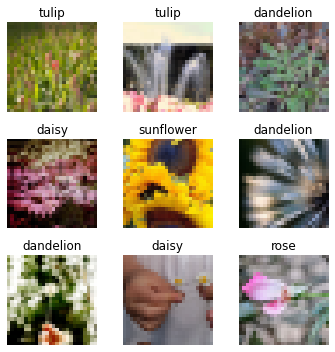

In [9]:
data.show_batch(rows=3, figsize=(5,5))

In [10]:
print(data.classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [11]:
len(data.classes),data.c

(5, 5)

## Training: resnet34

Now we will train the convolutional neural network https://cs231n.github.io/convolutional-networks/

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.087409,1.444780,0.495495,00:16
1,1.684427,1.238009,0.471471,00:07
2,1.400942,1.121895,0.429429,00:05
3,1.258960,1.099385,0.433934,00:05


In [15]:
learn.save('stage-1')

## Results

Let us have a look at the results of our model

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

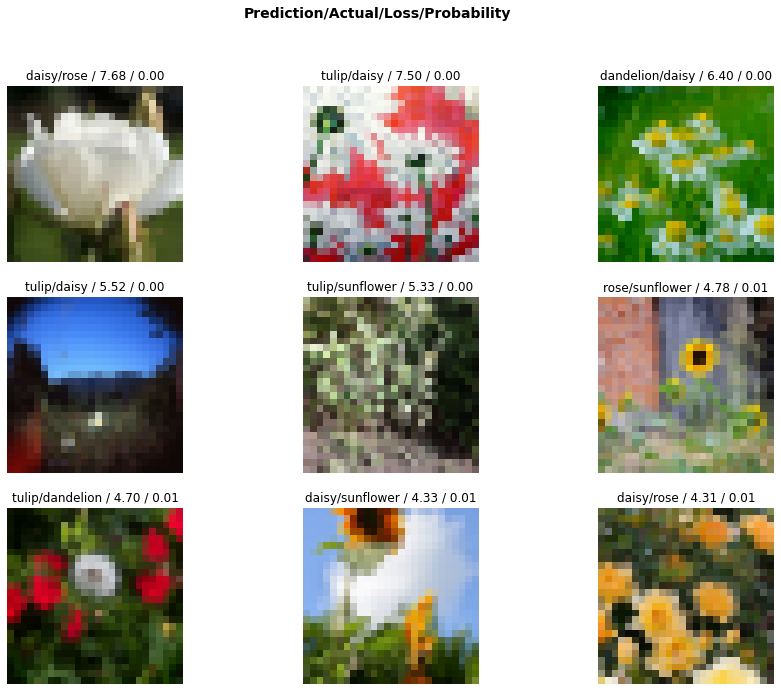

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
doc(interp.plot_top_losses)

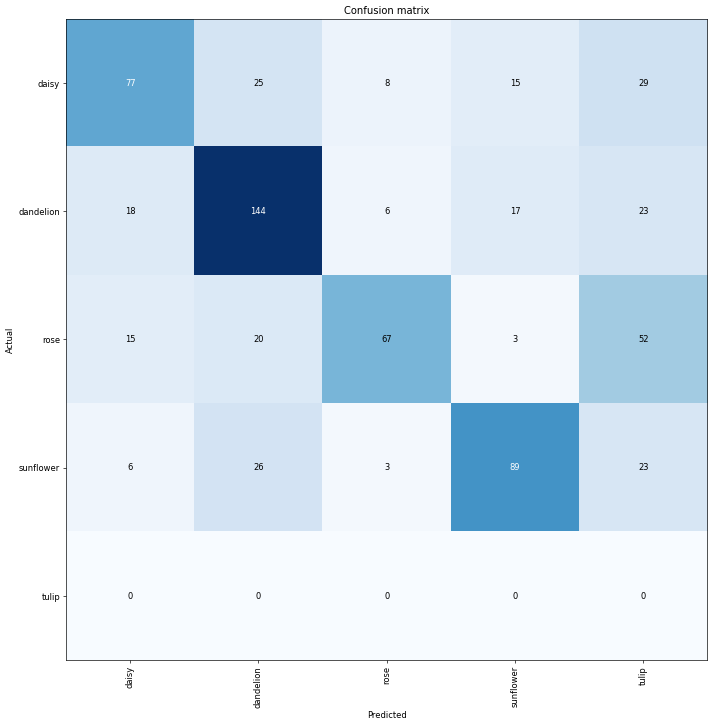

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=2)

[('rose', 'tulip', 52),
 ('daisy', 'tulip', 29),
 ('sunflower', 'dandelion', 26),
 ('daisy', 'dandelion', 25),
 ('dandelion', 'tulip', 23),
 ('sunflower', 'tulip', 23),
 ('rose', 'dandelion', 20),
 ('dandelion', 'daisy', 18),
 ('dandelion', 'sunflower', 17),
 ('daisy', 'sunflower', 15),
 ('rose', 'daisy', 15),
 ('daisy', 'rose', 8),
 ('dandelion', 'rose', 6),
 ('sunflower', 'daisy', 6),
 ('rose', 'sunflower', 3),
 ('sunflower', 'rose', 3)]

## Retrain

Let us add more cycles to the training

In [21]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.157157,1.093665,0.415916,00:05
1,1.141939,1.089139,0.426426,00:05
2,1.154341,1.049228,0.382883,00:05
3,1.141557,1.150779,0.432432,00:05
4,1.093607,1.012819,0.400901,00:05
5,1.053744,0.994084,0.375375,00:05
6,1.013984,1.025782,0.399399,00:05
7,0.970681,0.980847,0.381381,00:05
8,0.939268,0.986036,0.388889,00:05
9,0.930083,0.980168,0.399399,00:05


## Conclusion

In conclusion, I have managed to train a CNN to distinguish flowers- but not well!